In [2]:
%pip install -r requirements.txt

  Obtaining dependency information for pytorch-tcn from https://files.pythonhosted.org/packages/4f/84/85f4d0fa4c3678ecfae6d9bc86a8815727a47a7e7444284be79741d5b405/pytorch_tcn-1.2.1-py3-none-any.whl.metadata
  Using cached pytorch_tcn-1.2.1-py3-none-any.whl.metadata (17 kB)
Using cached pytorch_tcn-1.2.1-py3-none-any.whl (14 kB)

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Modeling

## Import data

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pytorch_tcn import TCN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [5]:
url = "https://raw.githubusercontent.com/AsmitC/Austin_Trees/refs/heads/victournguyen/purpleair-pull-data/full_data_final.csv"
df = pd.read_csv(url)
print(f'Shape: {df.shape}')
df.head()

Shape: (139802, 19)


,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,Oak,Elm,Pecan,Crape Myrtle,Ashe Juniper,other,total_diameter,canopy_coverage_percentage,PRCP
0,2024-10-24T18:00:00Z,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,1192,426,2,49,10,130,22595.5,66.596351,0.0
1,2024-10-24T06:00:00Z,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,1192,426,2,49,10,130,22595.5,66.596351,0.0
2,2024-10-24T00:00:00Z,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,1192,426,2,49,10,130,22595.5,66.596351,0.0
3,2024-10-23T00:00:00Z,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,1192,426,2,49,10,130,22595.5,66.596351,0.0
4,2024-10-23T18:00:00Z,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,1192,426,2,49,10,130,22595.5,66.596351,0.0


## Make season variable

In [6]:
# Ensure 'time_stamp' column is datetime type
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

# Define a function to assign seasons based on specific start dates
def get_accurate_season(date):
    if pd.isna(date):
        return np.nan  # Return NaN if date is missing (NaT)
    
    month = date.month
    day = date.day
    
    if (month == 12 and day >= 21) or month in [1, 2] or (month == 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or month in [4, 5] or (month == 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or month in [7, 8] or (month == 9 and day < 22):
        return 'Summer'
    else:
        return 'Fall'

# Apply the function to create a new 'season' column
df['season'] = df['time_stamp'].apply(get_accurate_season)

# Display the first few rows
df[['time_stamp', 'season']].head()

,time_stamp,season
0,2024-10-24 18:00:00+00:00,Fall
1,2024-10-24 06:00:00+00:00,Fall
2,2024-10-24 00:00:00+00:00,Fall
3,2024-10-23 00:00:00+00:00,Fall
4,2024-10-23 18:00:00+00:00,Fall


### Encode Season Variable

In [7]:
before_drop = df.shape[0]
df = df.dropna(subset=['season'])
after_drop = df.shape[0]
print(f'Loset {(before_drop-after_drop)/before_drop*100:0.2f}% of data by removing NA')

# One-hot encode the 'season' column
df = pd.get_dummies(df, columns=['season'], prefix='season')

# Display the first few rows
df.head()

Loset 0.07% of data by removing NA


,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,Crape Myrtle,Ashe Juniper,other,total_diameter,canopy_coverage_percentage,PRCP,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,49,10,130,22595.5,66.596351,0.0,True,False,False,False
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,49,10,130,22595.5,66.596351,0.0,True,False,False,False
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,49,10,130,22595.5,66.596351,0.0,True,False,False,False
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,49,10,130,22595.5,66.596351,0.0,True,False,False,False
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,49,10,130,22595.5,66.596351,0.0,True,False,False,False


## Random Forest

In [5]:
df.columns

Index(['time_stamp', 'humidity', 'temperature', 'pressure', 'pm2.5_alt',
       'pm2.5_atm', 'sensor_index', 'latitude', 'longitude', 'altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'canopy_coverage_percentage', 'PRCP', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [8]:
# Define features and target
features = ['humidity', 'temperature', 'pressure','altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'latitude', 'longitude', 'canopy_coverage_percentage', 'PRCP']
target = 'pm2.5_alt'

# Drop NA values
before_drop = df.shape[0]
df = df.dropna(subset=features+[target])
after_drop = df.shape[0]
print(f'Lose {(before_drop-after_drop)/before_drop*100:0.2f}% of data by removing NA')

Lose 3.81% of data by removing NA


In [9]:
X = df[features]
y = df[target]

# Split df into training, val, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
param_grid = {
    'max_depth': [15, 16, 17, 18]
}

grid = GridSearchCV(RandomForestRegressor(min_samples_split=3, min_samples_leaf=3, n_estimators=190),
                    param_grid=param_grid, n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Print best parameters and score from grid search
print("Best parameters:", grid.best_params_)
print("Best mse:", -grid.best_score_)

# Get the best estimator
rf = grid.best_estimator_

Best parameters: {'max_depth': 18}
Best score: 23.469028992220643


In [12]:

rf_regressor = RandomForestRegressor(
    n_estimators=190,         # Number of trees in the forest
    max_depth=15,             # Maximum depth of each tree
    min_samples_split=3,      # Minimum samples required to split a node
    min_samples_leaf=3,       # Minimum samples required at a leaf node
    random_state=42           # Ensures reproducibility
)

# Step 2: Fit the model
rf_regressor.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = rf_regressor.predict(X_test)


# Step 4: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 26.783545894543757
R^2 Score: 0.43962840193733854


# XGBoost

In [28]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [10, 11, 12], # 10
    'learning_rate': [0.01, 0.02, 0.03], # 0.02
    'n_estimators': [600, 700], # 600
    'subsample': [0.8, 0.85, 0.9], # 0.9
    'colsample_bytree': [0.8, 0.85, 0.9] # 0.8
}

# Initialize the XGBoost regressor
xgb_ = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# CV
grid = GridSearchCV(estimator=xgb_, param_grid=param_grid, 
                    scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=1)

grid.fit(X_train, y_train)

# Display results
print("Best parameters:", grid.best_params_)
print("Best mse:", -grid.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 600, 'subsample': 0.9}
Best mse: 22.214858875924424


In [30]:
# Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 600, 'subsample': 0.9}
best_xgb = grid.best_estimator_

# Make predictions
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Mean Squared Error: {mse_xgb}")
print(f"R^2 Score: {r2_xgb}")

Mean Squared Error: 25.094898347781854
R^2 Score: 0.4749586800143848


# Neural Network

In [31]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(2)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(2)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------------
# Attention Layer
# ----------------------------
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(input_dim))

    def forward(self, x):
        # x shape: (batch_size, num_channels, sequence_length)
        attention_scores = torch.matmul(x.transpose(1, 2), self.attention_weights)
        attention_scores = torch.softmax(attention_scores, dim=-1)  # Normalize attention scores
        weighted_output = torch.matmul(x, attention_scores.unsqueeze(-1)).squeeze(-1)
        return weighted_output

# ----------------------------
# Temporal Convolutional Network (TCN) with Attention
# ----------------------------
class HybridTCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(HybridTCN, self).__init__()
        self.tcn = TCN(input_size, num_channels[-1], num_channels, kernel_size, dropout)
        self.attention = AttentionLayer(num_channels[-1])
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        # Input shape: (batch_size, num_channels, sequence_length)
        tcn_out = self.tcn.network(x)  # Output of TCN
        attended_out = self.attention(tcn_out)  # Attention over TCN outputs
        output = self.fc(attended_out)  # Final fully connected layer
        return output

# ----------------------------
# Initialize Hybrid TCN + Attention
# ----------------------------
# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Number of input features
output_size = 1  # Predicting PM2.5
num_channels = [16, 32, 64, 128]  # Number of filters in each layer
kernel_size = 5
dropout = 0.3
model = HybridTCN(input_size, output_size, num_channels, kernel_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# ----------------------------
# Training the Model
# ----------------------------
epochs = 100
train_loss = []
test_losses = []
stop_indicator = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_inputs, batch_targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_loss.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}")

    # ----------------------------
    # Evaluating the Model
    # ----------------------------
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch_inputs, batch_targets in test_loader:
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets.view(-1, 1))
            test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Test Loss: {avg_test_loss:.4f}")

        # Early stopping logic
        if epoch >= 10 and avg_test_loss > min(test_losses):
            stop_indicator += 1
        else:
            stop_indicator = 0

        if stop_indicator >= 10:
            print("Model plateaued. Stopping early.")
            break

# ----------------------------
# Plot Train vs Test Loss
# ----------------------------
plt.figure()
plt.plot(range(len(train_loss)), train_loss, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.title("Train vs Test Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/100:   0%|          | 0/3360 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 3360/3360 [01:37<00:00, 34.30it/s]


Epoch 1/100, Train Loss: 35.6445
Test Loss: 35.1846


Epoch 2/100: 100%|██████████| 3360/3360 [01:38<00:00, 34.22it/s]


Epoch 2/100, Train Loss: 31.7648
Test Loss: 34.7463


Epoch 3/100: 100%|██████████| 3360/3360 [01:37<00:00, 34.37it/s]


Epoch 3/100, Train Loss: 30.9960
Test Loss: 33.3173


Epoch 4/100: 100%|██████████| 3360/3360 [01:39<00:00, 33.84it/s]


Epoch 4/100, Train Loss: 30.3364
Test Loss: 33.0524


Epoch 5/100: 100%|██████████| 3360/3360 [04:29<00:00, 12.45it/s]  


Epoch 5/100, Train Loss: 30.0449
Test Loss: 32.5064


Epoch 6/100: 100%|██████████| 3360/3360 [17:53<00:00,  3.13it/s]   


Epoch 6/100, Train Loss: 29.6095
Test Loss: 32.0460


Epoch 7/100: 100%|██████████| 3360/3360 [09:06<00:00,  6.15it/s]    


Epoch 7/100, Train Loss: 29.4124
Test Loss: 32.0599


Epoch 8/100: 100%|██████████| 3360/3360 [02:23<00:00, 23.37it/s]


Epoch 8/100, Train Loss: 29.0829
Test Loss: 32.2501


Epoch 9/100: 100%|██████████| 3360/3360 [03:18<00:00, 16.94it/s] 


Epoch 9/100, Train Loss: 28.8957
Test Loss: 31.8053


Epoch 10/100: 100%|██████████| 3360/3360 [01:35<00:00, 35.35it/s]


Epoch 10/100, Train Loss: 28.7504
Test Loss: 31.9789


Epoch 11/100: 100%|██████████| 3360/3360 [01:30<00:00, 37.19it/s]


Epoch 11/100, Train Loss: 28.5178
Test Loss: 32.7481


Epoch 12/100: 100%|██████████| 3360/3360 [01:30<00:00, 37.03it/s]


Epoch 12/100, Train Loss: 28.3303
Test Loss: 31.1746


Epoch 13/100: 100%|██████████| 3360/3360 [01:32<00:00, 36.45it/s]


Epoch 13/100, Train Loss: 28.1957
Test Loss: 32.1658


Epoch 14/100: 100%|██████████| 3360/3360 [01:42<00:00, 32.71it/s]


Epoch 14/100, Train Loss: 28.0471
Test Loss: 31.8865


Epoch 15/100: 100%|██████████| 3360/3360 [01:45<00:00, 31.72it/s]


Epoch 15/100, Train Loss: 27.8366
Test Loss: 30.7690


Epoch 16/100: 100%|██████████| 3360/3360 [01:35<00:00, 35.34it/s]


Epoch 16/100, Train Loss: 27.6884
Test Loss: 30.6821


Epoch 17/100: 100%|██████████| 3360/3360 [01:37<00:00, 34.57it/s]


Epoch 17/100, Train Loss: 27.4884
Test Loss: 31.4461


Epoch 18/100: 100%|██████████| 3360/3360 [01:35<00:00, 35.22it/s]


Epoch 18/100, Train Loss: 27.3646
Test Loss: 30.7816


Epoch 19/100: 100%|██████████| 3360/3360 [01:35<00:00, 35.23it/s]


Epoch 19/100, Train Loss: 27.2223
Test Loss: 31.4651


Epoch 20/100: 100%|██████████| 3360/3360 [01:35<00:00, 35.27it/s]


Epoch 20/100, Train Loss: 27.0641
Test Loss: 30.3185


Epoch 21/100: 100%|██████████| 3360/3360 [01:34<00:00, 35.44it/s]


Epoch 21/100, Train Loss: 26.9243
Test Loss: 30.4374


Epoch 22/100: 100%|██████████| 3360/3360 [01:37<00:00, 34.61it/s]


Epoch 22/100, Train Loss: 26.8887
Test Loss: 30.7473


Epoch 23/100: 100%|██████████| 3360/3360 [01:42<00:00, 32.90it/s]


Epoch 23/100, Train Loss: 26.7799
Test Loss: 31.7041


Epoch 24/100: 100%|██████████| 3360/3360 [01:41<00:00, 33.17it/s]


Epoch 24/100, Train Loss: 26.6530
Test Loss: 29.7381


Epoch 25/100: 100%|██████████| 3360/3360 [01:37<00:00, 34.56it/s]


Epoch 25/100, Train Loss: 26.4938
Test Loss: 32.7014


Epoch 26/100: 100%|██████████| 3360/3360 [01:34<00:00, 35.71it/s]


Epoch 26/100, Train Loss: 26.4809
Test Loss: 30.1747


Epoch 27/100: 100%|██████████| 3360/3360 [01:34<00:00, 35.42it/s]


Epoch 27/100, Train Loss: 26.4034
Test Loss: 29.4371


Epoch 28/100: 100%|██████████| 3360/3360 [01:36<00:00, 34.88it/s]


Epoch 28/100, Train Loss: 26.2932
Test Loss: 30.0322


Epoch 29/100: 100%|██████████| 3360/3360 [01:35<00:00, 35.28it/s]


Epoch 29/100, Train Loss: 26.2508
Test Loss: 30.1136


Epoch 30/100: 100%|██████████| 3360/3360 [01:35<00:00, 35.17it/s]


Epoch 30/100, Train Loss: 26.2720


# Interpretability

In [9]:
import matplotlib.pyplot as plt

plt.ioff()

## Residual Plot

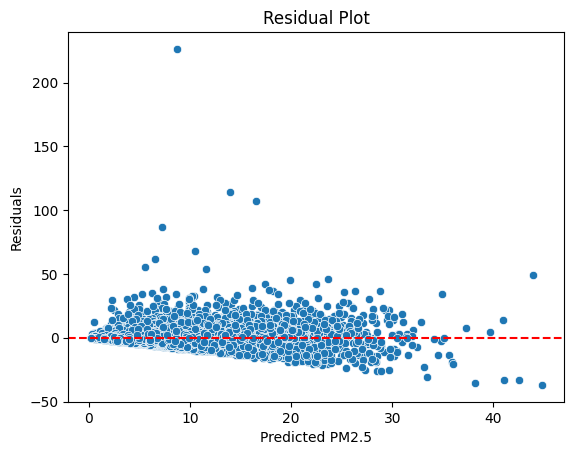

In [15]:
import seaborn as sns

y_pred = rf_regressor.predict(X_test)
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted PM2.5")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.savefig('residual_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## PDP

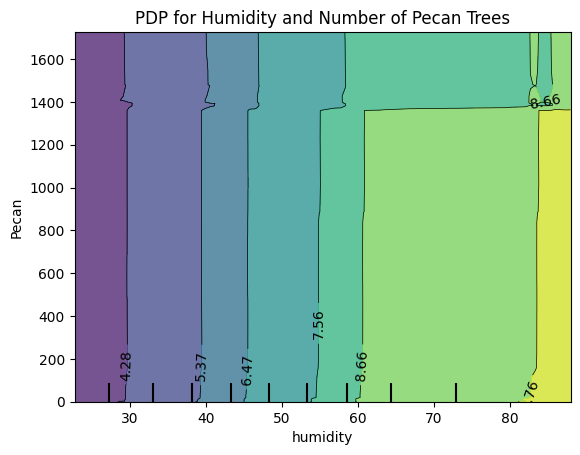

In [13]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

# features_PDP = ['humidity']
features_PDP = [('humidity', 'Pecan')]

PartialDependenceDisplay.from_estimator(rf_regressor, X, features_PDP, kind='average')
plt.title('PDP for Humidity and Number of Pecan Trees')
plt.show()

In [32]:
for f in features:
    PartialDependenceDisplay.from_estimator(rf_regressor, X, [f], kind='average')
    name = f.lower().replace(' ', '_')
    title_case = f.replace('_', ' ').replace('PRCP', 'Precipitation').title()
    plt.title(f'PDP for {title_case}')
    plt.xlabel(title_case)
    plt.savefig(f'./plots/pdp_{name}', dpi=300, bbox_inches='tight')
    plt.close()

## ICE

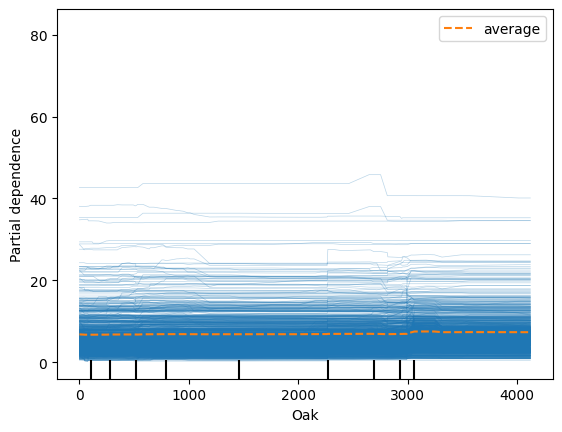

In [13]:
# Takes a long time to run
PartialDependenceDisplay.from_estimator(rf_regressor, X, features_PDP, kind='both')
plt.title('ICE plot')
plt.show()

## ALE

In [ ]:
from PyALE import ale

ale_eff = ale(X=X, model=rf_regressor, feature=features_PDP, grid_size=50, include_CI=False)
plt.title('ALE plot')
plt.show()

## SHAP

In [21]:
import shap

explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer(X_train.sample(n=5000, random_state=42))

In [28]:
plt.figure()
shap.plots.waterfall(shap_values[2], show=False)
plt.title('Shapley Value Waterfall Plot')
plt.savefig('./plots/shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.title('Shapley Value Beeswarm Plot')
plt.savefig('./plots/shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()